In [1]:
### Benjamin Tollison ###
import sympy as sp
from numba import jit
from IPython.display import display, Math, Latex
from sympy.solvers.solveset import linsolve
from sympy.solvers.pde import pdsolve
from sympy import  lambdify, Matrix,sin,cos, sinh, cosh, exp, pi, symbols, integrate, Function, Eq
import numpy as np
import scipy
import matplotlib.pyplot as plt
def displayEquations(LHS,RHS):
    left = sp.latex(LHS)
    right = sp.latex(RHS)
    display(Math(left + '=' + right))
    np.set_printoptions(suppress=True)

In [2]:
rho = 0.002377#1.2250554566 # kg/m
alpha,delta_E,theta = symbols('\\alpha \\delta_E \\theta')
gamma = theta - alpha
W = 20500# *0.453592 # kg
S_W = 300#*0.3048**2 # m^2
c_W = 11.32#*0.3048 # m
v = 500# * 0.3048 # m/s
q_infty = 0.5*rho*v**2
C_L = 0.14 + 4.2*alpha - 4.8*alpha**2 + 0.44*delta_E
C_M = -0.02 + 0.04*alpha - 0.6*delta_E - 0.08*alpha*delta_E + .08*delta_E**2 + 0.5*alpha**2*delta_E
alpha_0_symbol,delta_E0_symbol = symbols('\\alpha_0 \\delta_{E_0}')
C_L_alpha = lambdify((alpha,delta_E),C_L.diff(alpha))
C_L_delta_E = lambdify((alpha,delta_E),C_L.diff(delta_E))
C_M_alpha = lambdify((alpha,delta_E),C_M.diff(alpha))
C_M_delta_E = lambdify((alpha,delta_E),C_M.diff(delta_E))
C_L_lambda = lambdify((alpha,delta_E),C_L)
C_M_lambda = lambdify((alpha,delta_E),C_M)
alpha_0,delta_E0 = 0,0
iterations = 0
lift_trim = W/(q_infty*S_W)
while True:
  iterations += 1
  if -1e-3 < C_L_lambda(alpha_0,delta_E0) - lift_trim < 1e-3 and -1e-3 < C_M_lambda(alpha_0,delta_E0) < 1e-3:
    break
  elif iterations > 1e7:
    break
  else:
    iterations += 1
    jacobian = np.array([[C_L_alpha(alpha_0,delta_E0),C_L_delta_E(alpha_0,delta_E0)],\
      [C_M_alpha(alpha_0,delta_E0),C_M_delta_E(alpha_0,delta_E0)]])
    b = np.array([C_L_lambda(alpha_0,delta_E0),C_M_lambda(alpha_0,delta_E0)])
    x = np.linalg.inv(jacobian) @ b
    alpha_0 = x[0]
    delta_E0 = x[1]
displayEquations(alpha_0_symbol,alpha_0)
displayEquations(delta_E0_symbol,delta_E0)
print('C_L should be really close to {}'.format(lift_trim))
print('C_L = {}'.format(C_L_lambda(alpha_0,delta_E0)))
print('C_M = {}'.format(C_M_lambda(alpha_0,delta_E0)))
print('number of iterations = {}'.format(iterations))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

C_L should be really close to 0.22998176973776469
C_L = 0.23041206201664494
C_M = -0.0009006712536773279
number of iterations = 2754733


In [3]:
# using a solver
C_L_lambda = lambda alpha,delta_E: 0.14 + 4.2*alpha - 4.8*alpha**2 + 0.44*delta_E
C_M_lambda = lambda alpha,delta_E: -0.02 + 0.04*alpha - 0.6*delta_E - 0.08*alpha*delta_E + 0.8*delta_E**2 + 0.5*alpha**2*delta_E
def coeffiecent_array(x0:list)->list:
  alpha = x0[0]
  delta_E = x0[1]
  coefficent_of_lift = q_infty*S_W*C_L_lambda(x0[0],x0[1]) 
  coefficent_of_moment = q_infty*S_W*c_W*(-.02+.04*x[0]-.6*x[1]-.08*x[0]*x[1]+.08*x[1]**2+0.5*(x[0]**2)*x[1])
  return [coefficent_of_lift,coefficent_of_moment]
function_array = [C_L_lambda,C_M_lambda]
root_solver = scipy.optimize.fsolve(coeffiecent_array,[0,0],xtol=1e-12)
alpha_0 = root_solver[0]
delta_E0 = root_solver[1]
displayEquations(alpha_0_symbol,alpha_0)
displayEquations(delta_E0_symbol,delta_E0)

c:\Users\benja\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [4]:
# linear approximation
A = np.array([[4.2,0.44],[0.04,-0.6]])
A1 = np.array([[lift_trim-0.14,0.44],[0.02,-0.6]])
A2 = np.array([[4.2,lift_trim-0.14],[0.04,0.02]])
alpha_0 = np.linalg.det(A1) / np.linalg.det(A)
delta_E0 = np.linalg.det(A2) / np.linalg.det(A)
displayEquations(alpha_0_symbol,alpha_0)
displayEquations(delta_E0_symbol,delta_E0)
print('C_L should be really close to {}'.format(lift_trim))
print('C_L = {}'.format(C_L_lambda(alpha_0,delta_E0)))
print('C_M = {}'.format(C_M_lambda(alpha_0,delta_E0)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

C_L should be really close to 0.22998176973776469
C_L = 0.2270430180309649
C_M = 0.0008561072213999958


In [5]:
A = np.array([[4.2,0.44],[0.04,-0.6]])
b = np.array([lift_trim-0.14,0.02])
x = np.linalg.inv(A) @ b
displayEquations(alpha_0_symbol,x[0])
displayEquations(delta_E0_symbol,x[1])

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [6]:
# task 4
A = np.array([[-1,1,0],[0,1,0],[0,0,1]])
m = W/32.2 # lbm
inertia = 55814*32.174 # lb/ft^3
def LiftFunction(alpha,delta_E,Q):
  C_L = 0.14 + 4.2*alpha - 4.8*alpha**2 + 0.44*delta_E + (30.5+41.3*alpha)*Q
  denominator = q_infty*S_W*m*v
  return C_L/denominator
def PartialAlphaLiftFunction(alpha,delta_E,Q):
  C_L_alpha = 4.2 + 2*4.8*alpha + 41.3*Q
  denominator = q_infty*S_W*m*v
  return C_L_alpha/denominator
def PartialLittleQLiftFunction(alpha,delta_E,Q):
  C_L_q = 30.5 + 41.3*alpha
  denominator = q_infty*S_W*m*v
  return C_L_q/denominator
def MomentFunction(alpha,delta_E,Q):
  constant = q_infty*S_W*c_W / inertia
  C_Mref = -0.02 + 0.04*alpha - 0.6*delta_E - 0.08*alpha*delta_E + 0.08*delta_E**2 + \
    0.5*alpha**2*delta_E - (5.16+3.55*alpha+35.9*alpha**2)*Q
  return constant*C_Mref
def PartialAlphaMomentFunction(alpha,delta_E,Q):
  C_Mref_alpha = 0.04 - 0.08*delta_E + \
    alpha*delta_E - (3.55+2*35.9*alpha)*Q
  constant = q_infty*S_W*c_W / inertia
  return constant*C_Mref_alpha
def PartialLittleQMomentFunction(alpha,delta_E,Q):
  constant = q_infty*S_W*c_W / inertia
  C_Mref = -(5.16+3.55*alpha+35.9*alpha**2)
  return constant*C_Mref
def Jacobian(alpha,delta_E,Q):
  j = np.array([[PartialAlphaLiftFunction(alpha,delta_E,Q),0,PartialLittleQLiftFunction(alpha,delta_E,Q)],
                [0,0,1],
                [PartialAlphaMomentFunction(alpha,delta_E,Q),0,PartialLittleQMomentFunction(alpha,delta_E,Q)]])
  return j
def delta_E_array(alpha,delta_E,Q):
  L_delta_E = 0.44 
  Q_delta_E = 0
  M_delta_E = -0.6 - 0.08*alpha + 2*0.08*delta_E + 0.5*alpha**2
  constant = q_infty*S_W*c_W / inertia
  array = np.array([L_delta_E,Q_delta_E,M_delta_E*constant])
  return array
print(delta_E_array(alpha_0,delta_E0,0))

[ 0.44        0.         -0.34092847]


In [7]:
Q = symbols('Q')
C_L = 0.14 + 4.2*alpha - 4.8*alpha**2 + 0.44*delta_E + (30.5+41.3*alpha)*Q
C_M_cg = -0.02 + 0.04*alpha - 0.6*delta_E - 0.08*alpha*delta_E + 0.08*delta_E**2 + 0.5*alpha**2*delta_E -1*(5.16+3.55*alpha+35.9*alpha**2)*Q
lift_equation = q_infty*S_W*C_L/(m*v)
moment_equation = q_infty*S_W*c_W*C_M_cg/inertia
display(lift_equation.diff(alpha))
display(lift_equation.diff(Q))
display(moment_equation.diff(alpha))
display(moment_equation.diff(Q))
displayEquations('L_a',lift_equation.diff(alpha).subs({alpha:alpha_0,Q:0}))
displayEquations('L_q',lift_equation.diff(Q).subs({alpha:alpha_0,Q:0}))
displayEquations('M_a',moment_equation.diff(alpha).subs({alpha:alpha_0,Q:0,delta_E:delta_E0}))
displayEquations('M_q',moment_equation.diff(Q).subs({alpha:alpha_0,Q:0}))
L_a=lift_equation.diff(alpha).subs({alpha:alpha_0,Q:0})
L_Q=lift_equation.diff(Q).subs({alpha:alpha_0,Q:0})
M_a=moment_equation.diff(alpha).subs({alpha:alpha_0,Q:0,delta_E:delta_E0})
M_Q=moment_equation.diff(Q).subs({alpha:alpha_0,Q:0})
A_minus_lambda_of_suffering = np.array([[-L_a,0,1-L_Q],[0,0,1],[M_a,0,M_Q]])
# np.linalg.eig(A_minus_lambda_of_suffering)
displayEquations('1-L_q',1-L_Q)
L_dE = lift_equation.diff(delta_E).subs({alpha:alpha_0,delta_E:delta_E0,Q:0})
M_dE = moment_equation.diff(delta_E).subs({alpha:alpha_0,delta_E:delta_E0,Q:0})
displayEquations('L_dE',L_dE)
displayEquations('M_dE',M_dE)

11.5649166585366*Q - 2.68821307317073*\alpha + 1.1760932195122

11.5649166585366*\alpha + 8.54067695121951

-0.561899532527415*Q*(71.8*\alpha + 3.55) + 0.561899532527415*\alpha*\delta_E - 0.0449519626021932*\delta_E + 0.0224759813010966

-20.1721932177342*\alpha**2 - 1.99474334047232*\alpha - 2.89940158784146

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [8]:
# task 5
L_alpha,L_q,M_alpha,M_q,lambda_symbol = symbols('L_\\alpha L_q M_\\alpha M_q \\lambda')
A_minus_lambda = sp.Matrix([[L_alpha-lambda_symbol,0,L_q],[0,-lambda_symbol,0],[M_alpha,0,M_q-lambda_symbol]])
displayEquations('A-sI',A_minus_lambda)
displayEquations('det(A-sI)',A_minus_lambda.det())
eignvaules = sp.solve(A_minus_lambda.det(),lambda_symbol)
eignvaule_0,eignvaule_1,eignvaule_2 = eignvaules
lambda_symbol_1,lambda_symbol_2,lambda_symbol_3 = symbols('\\lambda_1 \\lambda_2 \\lambda_3')
displayEquations(lambda_symbol_1,eignvaules[0])
displayEquations(lambda_symbol_2,eignvaules[1])
displayEquations(lambda_symbol_3,eignvaules[2])
# displayEquations(lambda_symbol_1,eignvaule_0.subs({L_alpha:PartialAlphaLiftFunction(alpha_0,delta_E0,0)\
#   ,M_q:PartialLittleQMomentFunction(alpha_0,delta_E0,0),\
#     M_alpha:PartialAlphaMomentFunction(alpha_0,delta_E0,0),\
#       L_q:PartialLittleQLiftFunction(alpha_0,delta_E0,0)}))
# displayEquations(lambda_symbol_2,eignvaule_1.subs({L_alpha:PartialAlphaLiftFunction(alpha_0,delta_E0,0)\
#   ,M_q:PartialLittleQMomentFunction(alpha_0,delta_E0,0),\
#     M_alpha:PartialAlphaMomentFunction(alpha_0,delta_E0,0),\
#       L_q:PartialLittleQLiftFunction(alpha_0,delta_E0,0)}))
# displayEquations(lambda_symbol_3,eignvaule_2.subs({L_alpha:PartialAlphaLiftFunction(alpha_0,delta_E0,0)\
#   ,M_q:PartialLittleQMomentFunction(alpha_0,delta_E0,0),\
#     M_alpha:PartialAlphaMomentFunction(alpha_0,delta_E0,0),\
#       L_q:PartialLittleQLiftFunction(alpha_0,delta_E0,0)}))
displayEquations(lambda_symbol_1,0)
displayEquations(lambda_symbol_2,eignvaule_1.subs({L_alpha:L_a,L_q:L_Q,M_alpha:M_a,M_q:M_Q}))
displayEquations(lambda_symbol_3,eignvaule_2.subs({L_alpha:L_a,L_q:L_Q,M_alpha:M_a,M_q:M_Q}))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [25]:
eigncheck1 = lambdify((alpha,delta_E,Q),lift_equation.diff(alpha)+moment_equation.diff(Q))
x_cg = .35*c_W
x_ref = 0
def coeffiecent_array(x0:list)->list:
  alpha = x0[0]
  delta_E = x0[1]
  coefficent_of_lift = q_infty*S_W*C_L_lambda(x0[0],x0[1]) 
  coefficent_of_moment = q_infty*S_W*c_W*(-.02+.04*x[0]-.6*x[1]-.08*x[0]*x[1]+.08*x[1]**2+0.5*(x[0]**2)*x[1]) -C_L_lambda(x0[0],x0[1])*(x_ref-x_cg)/c_W
  return [coefficent_of_lift,coefficent_of_moment]
function_array = [C_L_lambda,C_M_lambda]
for i in np.linspace(0,1,100):
  x_ref = i*c_W
  root_solver = np.linalg.eig(coeffiecent_array,[0,0])
  alpha_var = root_solver[0]
  delta_var = root_solver[1]
  if eigncheck1(alpha_var,delta_var,0)>0:
    print('found unstable point')
    break

TypeError: eig() takes 1 positional argument but 2 were given

In [21]:

eig0_lambda = lambdify((L_alpha,L_q,M_alpha,M_q),eignvaule_0)
eig1_lambda = lambdify((L_alpha,L_q,M_alpha,M_q),eignvaule_1)
eig2_lambda = lambdify((L_alpha,L_q,M_alpha,M_q),eignvaule_2)
x_ref = .35*c_W
C_M_cg_lambda = lambda alpha,delta_E,x_cg: C_M_lambda(alpha,delta_E,0) - C_L_lambda(alpha,delta_E,0)*(x_ref-x_cg)/c_W
def C_M_cg(x0):
  alpha = x0[0]
  delta_E = x0[1]
  x_cg = x0[2] 
  return C_M_lambda(alpha,delta_E) - C_L_lambda(alpha,delta_E)*(x_ref-x_cg)/c_W
def coeffiecent_array(x):
  L = q_infty*S_W*C_L_lambda(x[0],x[1]) - lift_trim
  M_cg = q_infty*S_W*c_W*C_M_cg(x)
  return [L,M_cg,0]

stablity = {'x_cg':[],'alpha_0':[],'delta_E0':[],'q':[],'stablity':[]}
for i in np.linspace(0,1,100):
  x_cg = i*c_W
  alpha_0,delta_E0,q = scipy.optimize.fsolve(coeffiecent_array,[0,0,x_cg])
  stablity['alpha_0'].append(-alpha_0)
  stablity['delta_E0'].append(delta_E0)
  stablity['x_cg'].append(x_cg)
  stablity['q'].append(q)
  if PartialAlphaLiftFunction(-alpha_0,delta_E0,0) < PartialLittleQMomentFunction(-alpha_0,delta_E0,0):
    stablity['stablity'].append(False)
    print('there is an unstable point')
  else:
    stablity['stablity'].append(True)
import pandas as pd
pd.DataFrame(stablity)


,x_cg,alpha_0,delta_E0,q,stablity
0,0.000000,0.028833,-0.033880,1.567422,True
1,0.114343,0.028833,-0.033880,0.114343,True
2,0.228687,0.028833,-0.033880,0.228687,True
3,0.343030,0.028833,-0.033880,0.343030,True
4,0.457374,0.028833,-0.033880,0.457374,True
...,...,...,...,...,...
95,10.862626,0.028834,-0.033877,10.862626,True
96,10.976970,0.028834,-0.033876,10.976970,True
97,11.091313,0.028834,-0.033876,11.091313,True
98,11.205657,0.028834,-0.033876,11.205657,True


In [10]:
# task viii
eqn1 = -1.108665*alpha + 0.89999*Q  -0.123246*.0175
eqn2 = -0.67766*alpha -1.206373*Q - 11.129295*.0175
dof = linsolve([eqn1,eqn2],[alpha,Q])
alpha_solution,Q_soulution = next(iter(dof))
displayEquations(alpha,alpha_solution*180/np.pi)
displayEquations(Q,Q_soulution)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

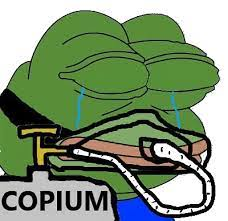

In [11]:
from IPython.display import Image
Image(filename='copium.jpg')